 # Product Recommendation Engine
 

In [1]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

# plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_json('tops_fashion.json')

In [3]:
print ('Number of data points : ', data.shape[0], \
       'Number of features/variables:', data.shape[1])


Number of data points :  183138 Number of features/variables: 19


In [4]:
# each product/item has 19 features in the raw dataset.
data.columns # prints column-names or feature-names.

Index(['asin', 'author', 'availability', 'availability_type', 'brand', 'color',
       'editorial_reivew', 'editorial_review', 'formatted_price',
       'large_image_url', 'manufacturer', 'medium_image_url', 'model',
       'product_type_name', 'publisher', 'reviews', 'sku', 'small_image_url',
       'title'],
      dtype='object')

There are 19 features(fields), we will be using only 6 features.

1. asin  ( Amazon standard identification number)
2. brand ( brand to which the product belongs to )
3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
5. medium_image_url  ( url of the image )
6. title (title of the product.)
7. formatted_price (price of the product)

In [5]:
ata = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]

In [6]:
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head() # prints the top rows in the table.

Number of data points :  183138 Number of features: 19


,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
0,B016I2TS4W,None,None,None,FNC7C,None,NaN,Minions Como Superheroes Ironman Women's O Nec...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Long Sleeve R...
1,B01N49AI08,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Izo Tunic
2,B01JDPCOHO,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Won Top
3,B01N19U5H5,None,None,None,Focal18,None,NaN,100% Brand New & Fashion<br> Quantity: 1 Piece...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[True, https://www.amazon.com/reviews/iframe?a...",None,https://images-na.ssl-images-amazon.com/images...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...
4,B004GSI2OS,None,Usually ships in 6-10 business days,now,FeatherLite,Onyx Black/ Stone,NaN,,$26.26,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...


# 5.1 Missing data for various features(Fields).

In [7]:

print(data['product_type_name'].describe())


count     183138
unique        72
top        SHIRT
freq      167794
Name: product_type_name, dtype: object


In [8]:

print(data['product_type_name'].unique())

['SHIRT' 'SWEATER' 'APPAREL' 'OUTDOOR_RECREATION_PRODUCT'
 'BOOKS_1973_AND_LATER' 'PANTS' 'HAT' 'SPORTING_GOODS' 'DRESS' 'UNDERWEAR'
 'SKIRT' 'OUTERWEAR' 'BRA' 'ACCESSORY' 'ART_SUPPLIES' 'SLEEPWEAR'
 'ORCA_SHIRT' 'HANDBAG' 'PET_SUPPLIES' 'SHOES' 'KITCHEN' 'ADULT_COSTUME'
 'HOME_BED_AND_BATH' 'MISC_OTHER' 'BLAZER' 'HEALTH_PERSONAL_CARE'
 'TOYS_AND_GAMES' 'SWIMWEAR' 'CONSUMER_ELECTRONICS' 'SHORTS' 'HOME'
 'AUTO_PART' 'OFFICE_PRODUCTS' 'ETHNIC_WEAR' 'BEAUTY'
 'INSTRUMENT_PARTS_AND_ACCESSORIES' 'POWERSPORTS_PROTECTIVE_GEAR' 'SHIRTS'
 'ABIS_APPAREL' 'AUTO_ACCESSORY' 'NONAPPARELMISC' 'TOOLS' 'BABY_PRODUCT'
 'SOCKSHOSIERY' 'POWERSPORTS_RIDING_SHIRT' 'EYEWEAR' 'SUIT'
 'OUTDOOR_LIVING' 'POWERSPORTS_RIDING_JACKET' 'HARDWARE' 'SAFETY_SUPPLY'
 'ABIS_DVD' 'VIDEO_DVD' 'GOLF_CLUB' 'MUSIC_POPULAR_VINYL'
 'HOME_FURNITURE_AND_DECOR' 'TABLET_COMPUTER' 'GUILD_ACCESSORIES'
 'ABIS_SPORTS' 'ART_AND_CRAFT_SUPPLY' 'BAG' 'MECHANICAL_COMPONENTS'
 'SOUND_AND_RECORDING_EQUIPMENT' 'COMPUTER_COMPONENT' 'JEWELRY'
 'B

In [9]:

product_type_count = Counter(list(data['product_type_name']))
product_type_count.most_common(10)

[('SHIRT', 167794),
 ('APPAREL', 3549),
 ('BOOKS_1973_AND_LATER', 3336),
 ('DRESS', 1584),
 ('SPORTING_GOODS', 1281),
 ('SWEATER', 837),
 ('OUTERWEAR', 796),
 ('OUTDOOR_RECREATION_PRODUCT', 729),
 ('ACCESSORY', 636),
 ('UNDERWEAR', 425)]

Basic stats for the feature(fields): brand

In [10]:

print(data['brand'].describe())



count     182987
unique     10577
top         Zago
freq         223
Name: brand, dtype: object


In [11]:
brand_count = Counter(list(data['brand']))
brand_count.most_common(10)

[('Zago', 223),
 ('XQS', 222),
 ('Yayun', 215),
 ('YUNY', 198),
 ('XiaoTianXin-women clothes', 193),
 ('Generic', 192),
 ('Boohoo', 190),
 ('Alion', 188),
 ('Abetteric', 187),
 ('TheMogan', 187)]

Basic stats for the feature(Fields): color

In [12]:
print(data['color'].describe())


count     64956
unique     7380
top       Black
freq      13207
Name: color, dtype: object


In [13]:
color_count = Counter(list(data['color']))
color_count.most_common(10)

[(None, 118182),
 ('Black', 13207),
 ('White', 8616),
 ('Blue', 3570),
 ('Red', 2289),
 ('Pink', 1842),
 ('Grey', 1499),
 ('*', 1388),
 ('Green', 1258),
 ('Multi', 1203)]

Basic stats for the feature(Fields): formatted_price

In [14]:
print(data['formatted_price'].describe())


count      28395
unique      3135
top       $19.99
freq         945
Name: formatted_price, dtype: object


In [15]:
price_count = Counter(list(data['formatted_price']))
price_count.most_common(10)

[(None, 154743),
 ('$19.99', 945),
 ('$9.99', 749),
 ('$9.50', 601),
 ('$14.99', 472),
 ('$7.50', 463),
 ('$24.99', 414),
 ('$29.99', 370),
 ('$8.99', 343),
 ('$9.01', 336)]

Basic stats for the feature: title

In [16]:
data.to_pickle('180k_apparel_data')

In [17]:
#about the dataframe row's which have null values price == None|Null
data = data.loc[~data['formatted_price'].isnull()]
print('Number of data points After eliminating price=NULL :', data.shape[0])

Number of data points After eliminating price=NULL : 28395


In [18]:
data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating color=NULL :', data.shape[0])

Number of data points After eliminating color=NULL : 28385


We brought down the number of data points from 183K to 28K.
We are processing only 28K points.

In [19]:
data.to_pickle('28k_apparel_data')

#  Code For Removing near duplicate items

 Understanding duplicates.

In [20]:
# read data from pickle file from previous stage
data = pd.read_pickle('28k_apparel_data')

# find number of products that have duplicate titles.
print(sum(data.duplicated('title')))
# we have 2325 products which have same title but different color

2325


2.Code for Remove duplicates

In [21]:
#read data from pickle file from previous stage
data = pd.read_pickle('28k_apparel_data')

In [22]:
data.head()

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
4,B004GSI2OS,None,Usually ships in 6-10 business days,now,FeatherLite,Onyx Black/ Stone,NaN,,$26.26,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...
6,B012YX2ZPI,None,Usually ships in 4-5 business days,now,HX-Kingdom Fashion T-shirts,White,NaN,This Personalized Special Olympics World Games...,$9.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Women's Unique 100% Cotton T - Special Olympic...
11,B001LOUGE4,None,None,None,Fitness Etc.,Black,NaN,Light Weight 2x1 Boy Beater Tank Top. Great t...,$11.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Ladies Cotton Tank 2x1 Ribbed Tank Top
15,B003BSRPB0,None,Usually ships in 6-10 business days,now,FeatherLite,White,NaN,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",HT-2001_Lime-1149-XL,https://images-na.ssl-images-amazon.com/images...,FeatherLite Ladies' Moisture Free Mesh Sport S...
21,B014ICEDNA,None,Usually ships in 4-5 business days,now,FNC7C,Purple,NaN,Supernatural Chibis Sam Dean And Castiel Women...,$7.50,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[True, https://www.amazon.com/reviews/iframe?a...",None,https://images-na.ssl-images-amazon.com/images...,Supernatural Chibis Sam Dean And Castiel Short...


In [23]:
# Remove All products with very few words in title
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


In [24]:
# Sort the whole data based on title (alphabetical order of title) 
data_sorted.sort_values('title',inplace=True, ascending=False)
data_sorted.head()

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
61973,B06Y1KZ2WB,None,Usually ships in 1-2 business days,now,Éclair,Black/Pink,"Perfect for summer adventures, feminine touch ...",NaN,$24.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Éclair Women's Printed Thin Strap Blouse Black...
133820,B010RV33VE,None,Usually ships in 4-5 business days,now,xiaoming,Pink,<p>Korean Style Womens' Sleeveless Loose Long ...,NaN,$18.19,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,xiaona10326758,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Womens Sleeveless Loose Long T-shirts...
81461,B01DDSDLNS,None,Usually ships in 4-5 business days,now,xiaoming,White,<br>1.xiaoming is a modern lifestyle brand tha...,NaN,$21.58,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,MxiaoCotds,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Women's White Long Sleeve Single Brea...
75995,B00X5LYO9Y,None,Usually ships in 4-5 business days,now,xiaoming,Red Anchors,Sleeve Style: Short Sleeve<br />Patten:Stripes...,NaN,$15.91,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Stripes Tank Patch/Bear Sleeve Anchor...
151570,B00WPJG35K,None,Usually ships in 4-5 business days,now,xiaoming,White,Material :Lace<br />This cardigan is imported ...,NaN,$14.32,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,xiaoming Sleeve Sheer Loose Tassel Kimono Woma...


Some data that are contain dupliacte titles that differ only in the last few words.(For working Information)

Titles 1:
16. woman's place is in the house and the senate shirts for Womens XXL White
17. woman's place is in the house and the senate shirts for Womens M Grey

Title 2:
25. tokidoki The Queen of Diamonds Women's Shirt X-Large
26. tokidoki The Queen of Diamonds Women's Shirt Small
27. tokidoki The Queen of Diamonds Women's Shirt Large

Title 3:
61. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
62. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
63. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt
64. psychedelic colorful Howling Galaxy Wolf T-shirt/Colorful Rainbow Animal Print Head Shirt for woman Neon Wolf t-shirt

In [25]:
indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)

In [26]:
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:
    
    previous_i = i

    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    a = data['title'].loc[indices[i]].split()

    # search for the similar products sequentially 
    j = i+1
    while j < num_data_points:

        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'Small']
        b = data['title'].loc[indices[j]].split()

        # store the maximum length of two strings
        length = max(len(a), len(b))

        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1

        # if the number of words in which both strings differ are > 2 , we are considering it as those two apperals are different
        # if the number of words in which both strings differ are < 2 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) > 2: # number of words in which both sensences differ
            # if both strings are differ by more than 2 words we include the 1st string index
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])

            # if the comaprision between is between num_data_points, num_data_points-1 strings and they differ in more than 2 words we include both
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])

            # start searching for similar apperals corresponds 2nd string
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

In [27]:
data = data.loc[data['asin'].isin(stage1_dedupe_asins)]

removed duplicate item that are differed in end

In [28]:
print('Number of data points : ', data.shape[0])

Number of data points :  17593


In [29]:
data.to_pickle('17k_apperal_data')

removing some products whose titles are not adjacent but very similar.

The data are
Examples:

Titles-1
 86261.  UltraClub Women's Classic Wrinkle-Free Long Sleeve Oxford Shirt, Pink, XX-Large
 115042. UltraClub Ladies Classic Wrinkle-Free Long-Sleeve Oxford Light Blue XXL

Titles-2
 75004.  EVALY Women's Cool University Of UTAH 3/4 Sleeve Raglan Tee
 109225. EVALY Women's Unique University Of UTAH 3/4 Sleeve Raglan Tees
 120832. EVALY Women's New University Of UTAH 3/4-Sleeve Raglan Tshirt

In [30]:
data = pd.read_pickle('17k_apperal_data')

In [37]:
# This code snippet takes significant amount of time.
# O(n^2) time.
# Takes about an hour to run on a decent computer.

indices = []
for i,row in data.iterrows():
    indices.append(i)

stage2_dedupe_asins = []
while len(indices)!=0:
    i = indices.pop()
    stage2_dedupe_asins.append(data['asin'].loc[i])
    # consider the first apperal's title
    a = data['title'].loc[i].split()
    # store the list of words of ith string in a, ex: a = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
    for j in indices:
        
        b = data['title'].loc[j].split()
        # store the list of words of jth string in b, ex: b = ['tokidoki', 'The', 'Queen', 'of', 'Diamonds', 'Women's', 'Shirt', 'X-Large']
        
        length = max(len(a),len(b))
        
        # count is used to store the number of words that are matched in both strings
        count  = 0

        # itertools.zip_longest(a,b): will map the corresponding words in both strings, it will appened None in case of unequal strings
        # example: a =['a', 'b', 'c', 'd']
        # b = ['a', 'b', 'd']
        # itertools.zip_longest(a,b): will give [('a','a'), ('b','b'), ('c','d'), ('d', None)]
        for k in itertools.zip_longest(a,b): 
            if (k[0]==k[1]):
                count += 1

        # if the number of words in which both strings differ are < 3 , we are considering it as those two apperals are same, hence we are ignoring them
        if (length - count) < 3:
            indices.remove(j)

In [ ]:
# from whole previous products we will consider only 
# the products that are found in previous cell 
data = data.loc[data['asin'].isin(stage2_dedupe_asins)]

In [32]:
print('Number of data points after stage two of dedupe: ',data.shape[0])
# from 17k apperals we reduced to 16k apperals

Number of data points after stage two of dedupe:  17593


In [33]:
data.to_pickle('16k_apperal_data')

# Text Processing part

In [31]:
data = pd.read_pickle('16k_apperal_data')

Code that removes stop words

In [32]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {"you'll", 'out', 'hasn', 'against', 'haven', 'the', 'then', 'why', 'isn', 'hadn', 'other', 'while', 'such', 'their', 'does', 'where', 'you', 'had', "you're", 'between', 'above', 'because', 'been', 'being', 'not', 'needn', 'hers', "hasn't", 'what', 'those', 'aren', "doesn't", "that'll", 've', 'how', 'to', 'or', 'nor', 'now', 'mustn', 'theirs', 'will', 'with', 'be', "don't", 'few', 'most', 'won', 'itself', 'from', 'wouldn', 'are', 'very', 'herself', 'its', 'did', 'them', 'before', 'on', 'himself', 'y', 'here', 'no', 'having', "wasn't", 'we', 'can', 'mightn', 'don', 'until', 'up', 'again', 'but', 'just', 'which', 'o', 'ma', 'wasn', 'through', "didn't", "haven't", 'my', "should've", 'only', 'down', 'each', 'his', 'her', 'some', 'was', 'shouldn', 'during', 'whom', 'm', 'all', 'once', "needn't", 'have', 'over', 'than', 't', "weren't", 'is', 'didn', 'he', 'there', 'as', "mightn't", 'were', 'i', 'who', 'ourselves', 'do', 'own', 'yourselves', "it's", 'too', 'about', 'same',

In [33]:
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [34]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

15.572732721819193 seconds


after removing the stop words


In [6]:
data.head()

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
4,B004GSI2OS,None,Usually ships in 6-10 business days,now,FeatherLite,Onyx Black/ Stone,NaN,,$26.26,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...
6,B012YX2ZPI,None,Usually ships in 4-5 business days,now,HX-Kingdom Fashion T-shirts,White,NaN,This Personalized Special Olympics World Games...,$9.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Women's Unique 100% Cotton T - Special Olympic...
15,B003BSRPB0,None,Usually ships in 6-10 business days,now,FeatherLite,White,NaN,FeatherLite Ladies' Moisture Free Mesh Sport S...,$20.54,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",HT-2001_Lime-1149-XL,https://images-na.ssl-images-amazon.com/images...,FeatherLite Ladies' Moisture Free Mesh Sport S...
27,B014ICEJ1Q,None,Usually ships in 4-5 business days,now,FNC7C,Purple,NaN,Supernatural Chibis Sam Dean And Castiel Women...,$7.39,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Supernatural Chibis Sam Dean And Castiel O Nec...
46,B01NACPBG2,None,Usually ships in 1-2 business days,now,Fifth Degree,Black,NaN,Length 27.4 inches Width 15.4 inches Short sle...,$6.95,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Fifth Degree Womens Gold Foil Graphic Tees Jun...


In [7]:
data.tail()

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
183081,B01MRV2IFS,None,Usually ships in 1-2 business days,now,YueLian,Black,Note:<br>1. Due to limitations in photography ...,NaN,$19.25,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,YueLian Women's Chiffon Short Sleeves Sun Prot...
183092,B01LY4QWLF,None,Usually ships in 1-2 business days,now,Vintage America,White,Vintage America Women's Large Lace Up Collared...,NaN,$23.24,https://images-na.ssl-images-amazon.com/images...,Vintage America,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,Vintage America,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Vintage America Women's Large Lace Up Collared...
183096,B07167SCNH,None,Usually ships in 2-3 business days,now,Tart Collections,Black,Color/pattern: black. Approximately 28in from ...,NaN,$29.99,https://images-na.ssl-images-amazon.com/images...,TART,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,TART,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,"Tart Womens Collections Ann Wrap Top, Xs, Black"
183101,B07575N2WX,None,Usually ships in 1-2 business days,now,Soprano,Gray,Soprano Womens Small Tie-Fringe Slub-Knit Tank...,NaN,$22.83,https://images-na.ssl-images-amazon.com/images...,Soprano,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,Soprano,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Soprano Womens Small Tie-Fringe Slub-Knit Tank...
183120,B01NCO06S0,None,Usually ships in 1-2 business days,now,Faded Glory,Blue/Grey,Faded Glory Women's Plaid Tunic Shirt: 100% ra...,NaN,$18.99,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Faded Glory Women's Plaid Button Down 2 Pocket...


In [3]:
data.to_pickle('16k_apperal_data_preprocessed')

# Stemming

In [4]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
print(stemmer.stem('arguing'))
print(stemmer.stem('fishing'))

argu
fish


#  !!   Text based product similarity !!

Till now the data set

In [34]:
data = pd.read_pickle('16k_apperal_data_preprocessed')
data.head()

,asin,author,availability,availability_type,brand,color,editorial_reivew,editorial_review,formatted_price,large_image_url,manufacturer,medium_image_url,model,product_type_name,publisher,reviews,sku,small_image_url,title
0,B016I2TS4W,None,None,None,FNC7C,None,NaN,Minions Como Superheroes Ironman Women's O Nec...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Minions Como Superheroes Ironman Long Sleeve R...
1,B01N49AI08,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Izo Tunic
2,B01JDPCOHO,None,None,None,FIG Clothing,None,NaN,Sizing runs on the small side. FIG® recommends...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,FIG Clothing Womens Won Top
3,B01N19U5H5,None,None,None,Focal18,None,NaN,100% Brand New & Fashion<br> Quantity: 1 Piece...,None,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[True, https://www.amazon.com/reviews/iframe?a...",None,https://images-na.ssl-images-amazon.com/images...,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...
4,B004GSI2OS,None,Usually ships in 6-10 business days,now,FeatherLite,Onyx Black/ Stone,NaN,,$26.26,https://images-na.ssl-images-amazon.com/images...,None,https://images-na.ssl-images-amazon.com/images...,None,SHIRT,None,"[False, https://www.amazon.com/reviews/iframe?...",None,https://images-na.ssl-images-amazon.com/images...,Featherlite Ladies' Long Sleeve Stain Resistan...


In [35]:
# Utility Functions 

#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

#  Bag of Words (BoW) on product titles for text-based matching.

In [36]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus

(183138, 41072)

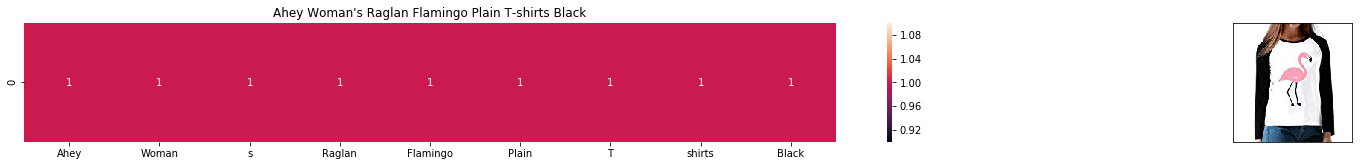

ASIN : B01M0YYFK6
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan Flamingo Plain T-shirts Black
Euclidean similarity with the query image : 0.0


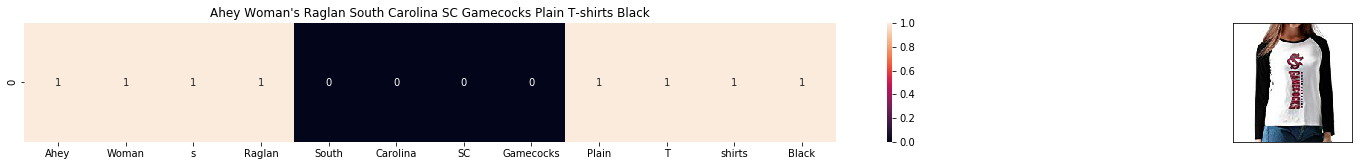

ASIN : B01LWQRUO3
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan South Carolina SC Gamecocks Plain T-shirts Black
Euclidean similarity with the query image : 2.23606797749979


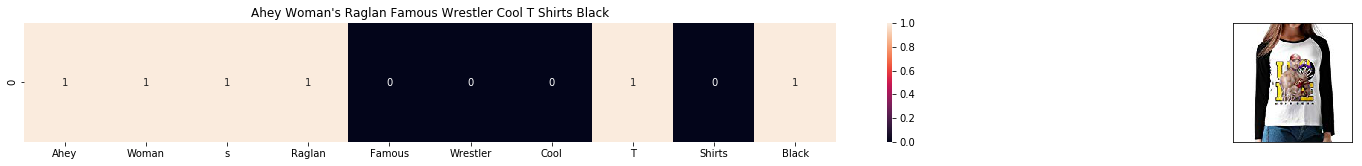

ASIN : B01M0NB75I
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan Famous Wrestler Cool T Shirts Black
Euclidean similarity with the query image : 2.23606797749979


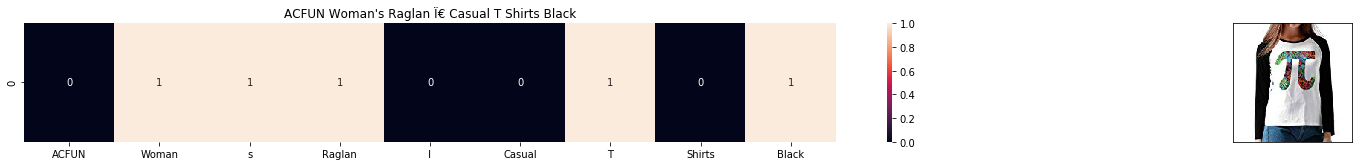

ASIN : B01MDMCI5J
Brand: ACFUN
Title: ACFUN Woman's Raglan Ï€ Casual T Shirts Black
Euclidean similarity with the query image : 2.23606797749979


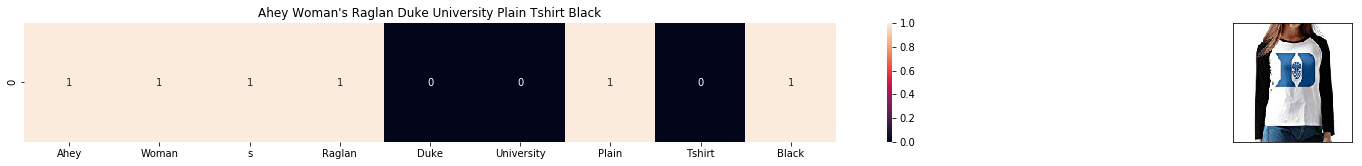

ASIN : B01LX2EFXJ
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan Duke University Plain Tshirt Black
Euclidean similarity with the query image : 2.23606797749979


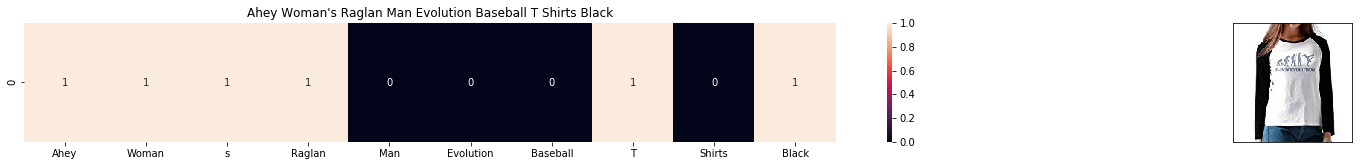

ASIN : B01M0YVVN8
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan Man Evolution Baseball T Shirts Black
Euclidean similarity with the query image : 2.23606797749979


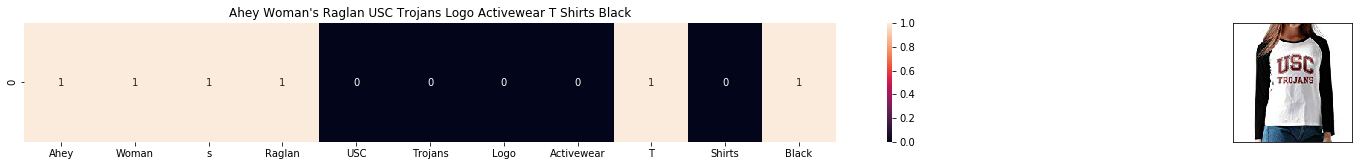

ASIN : B01M1A9QVR
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan USC Trojans Logo Activewear T Shirts Black
Euclidean similarity with the query image : 2.449489742783178


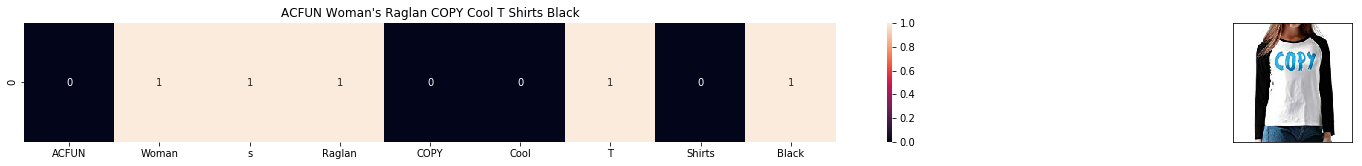

ASIN : B01M320HNY
Brand: ACFUN
Title: ACFUN Woman's Raglan COPY Cool T Shirts Black
Euclidean similarity with the query image : 2.449489742783178


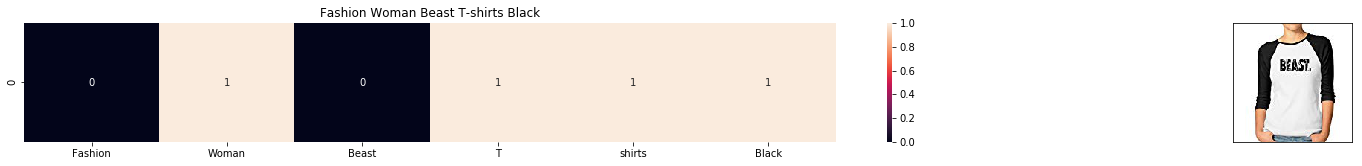

ASIN : B01G9YHRF6
Brand: LOVELIF Sleeve Raglan
Title: Fashion Woman Beast T-shirts Black
Euclidean similarity with the query image : 2.449489742783178


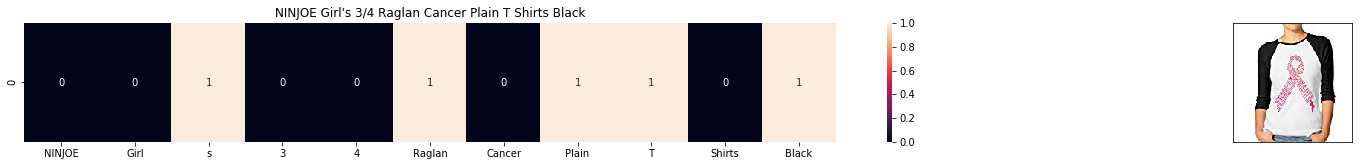

ASIN : B01K7M5AMS
Brand: NINJOE
Title: NINJOE Girl's 3/4 Raglan Cancer Plain T Shirts Black
Euclidean similarity with the query image : 2.449489742783178


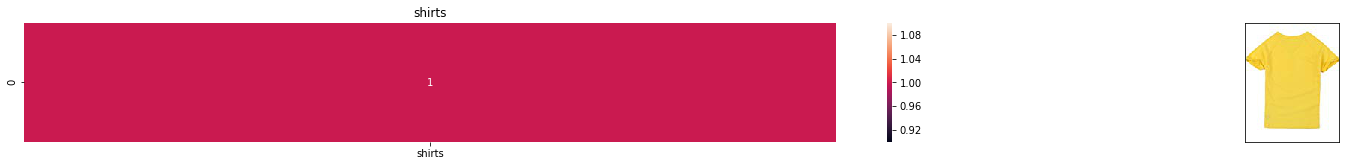

ASIN : B074HZVQRL
Brand: General
Title: shirts
Euclidean similarity with the query image : 2.449489742783178


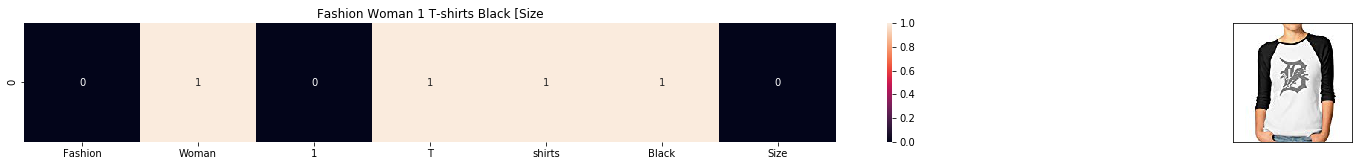

ASIN : B01FRZH4SS
Brand: LOVELIF Sleeve Raglan
Title: Fashion Woman 1 T-shirts Black [Size
Euclidean similarity with the query image : 2.449489742783178


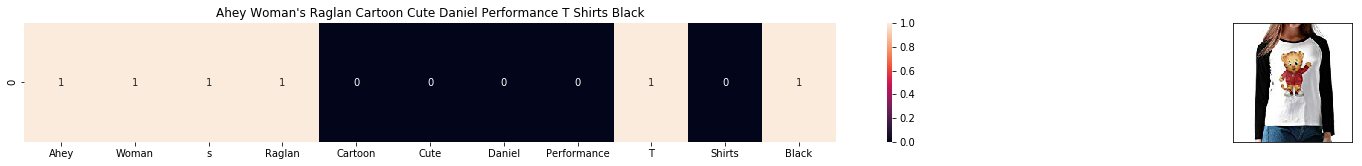

ASIN : B01M0YZC2P
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan Cartoon Cute Daniel Performance T Shirts Black
Euclidean similarity with the query image : 2.449489742783178


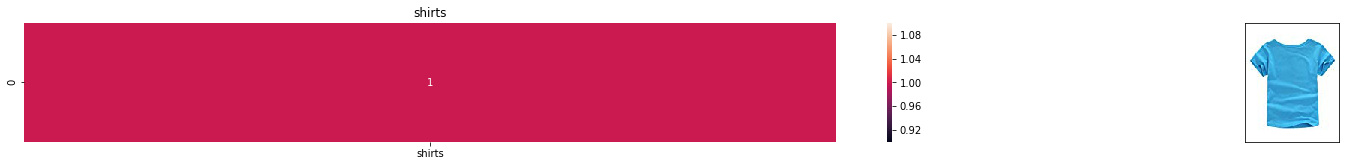

ASIN : B074J7886V
Brand: General
Title: shirts
Euclidean similarity with the query image : 2.449489742783178


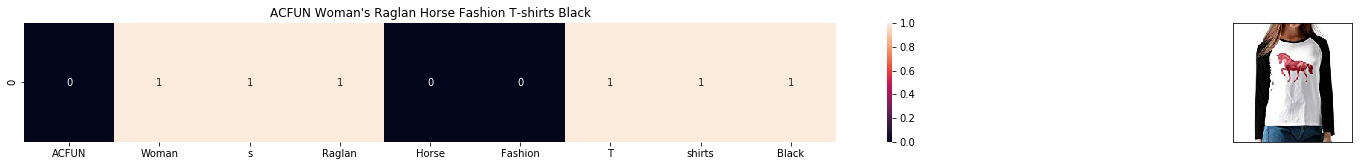

ASIN : B01M7PP8Z8
Brand: ACFUN
Title: ACFUN Woman's Raglan Horse Fashion T-shirts Black
Euclidean similarity with the query image : 2.449489742783178


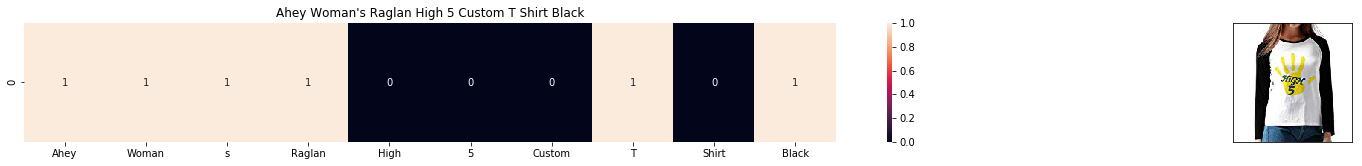

ASIN : B01LY1N34L
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan High 5 Custom T Shirt Black
Euclidean similarity with the query image : 2.449489742783178


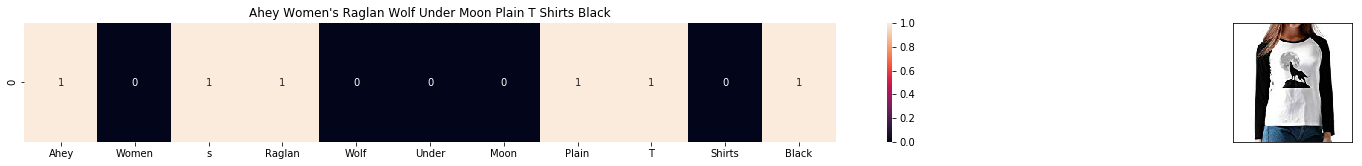

ASIN : B01LXE7IR9
Brand: Ahey Sports T-shirts
Title: Ahey Women's Raglan Wolf Under Moon Plain T Shirts Black
Euclidean similarity with the query image : 2.449489742783178


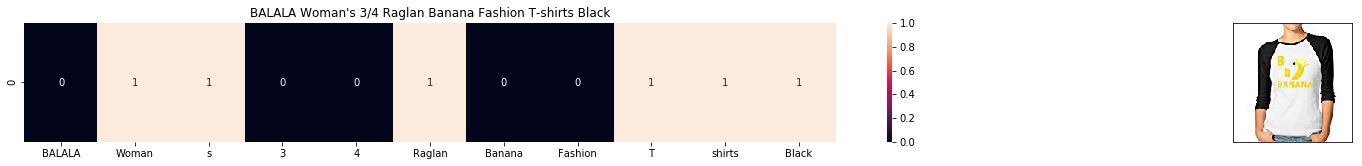

ASIN : B01MFGCIQK
Brand: balala
Title: BALALA Woman's 3/4 Raglan Banana Fashion T-shirts Black
Euclidean similarity with the query image : 2.449489742783178


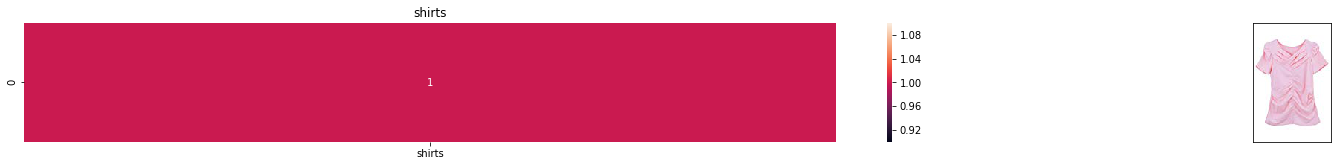

ASIN : B074PKQ2M6
Brand: General
Title: shirts
Euclidean similarity with the query image : 2.449489742783178


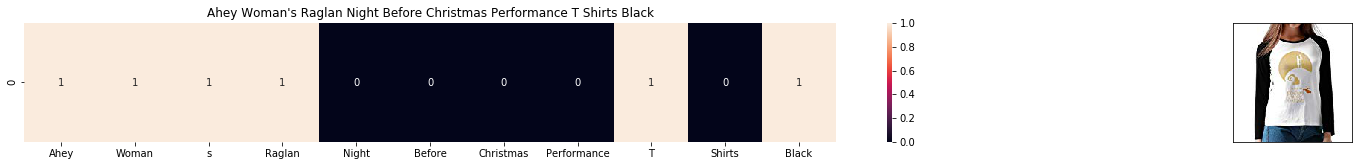

ASIN : B01M0NB4GF
Brand: Ahey Sports T-shirts
Title: Ahey Woman's Raglan Night Before Christmas Performance T Shirts Black
Euclidean similarity with the query image : 2.449489742783178


In [37]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
       
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)


bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value 



#  TF-IDF based product similarity

In [38]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

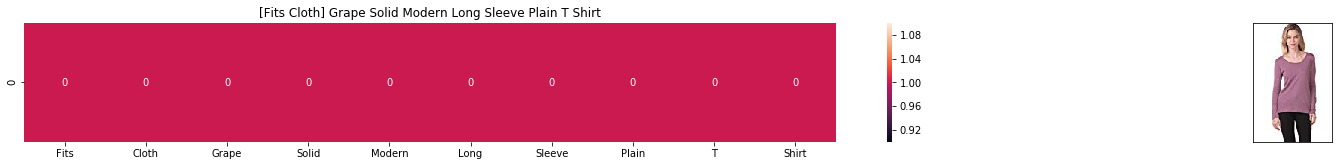

ASIN : B00TAEHGGS
BRAND : Fitscloth
Eucliden distance from the given image : 0.0


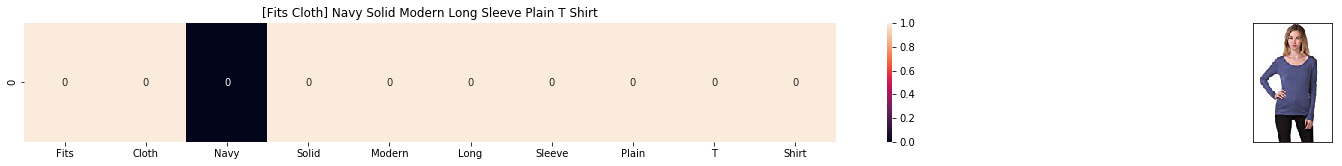

ASIN : B00TAEHJOC
BRAND : Fitscloth
Eucliden distance from the given image : 0.6264210130682765


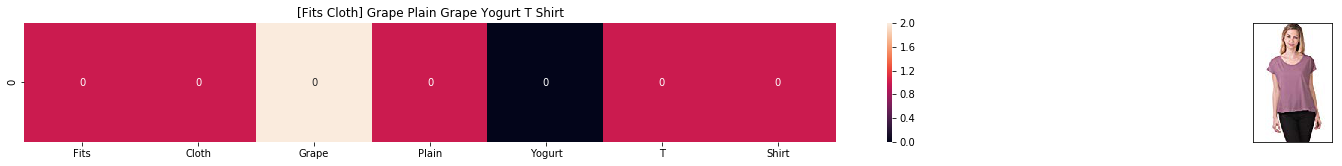

ASIN : B00TAEHPX2
BRAND : Fitscloth
Eucliden distance from the given image : 0.7143053671157966


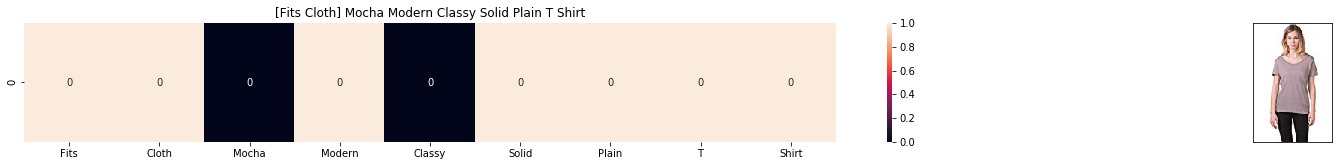

ASIN : B00TAEHKBY
BRAND : Fitscloth
Eucliden distance from the given image : 0.820678298520703


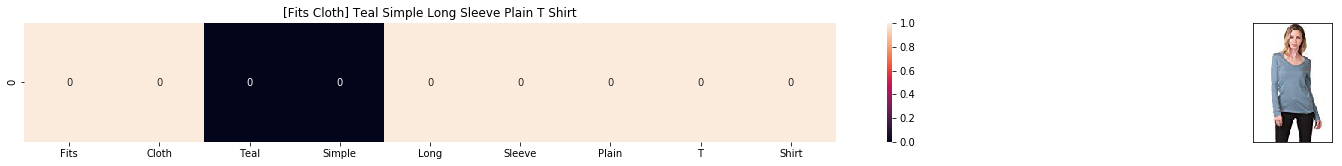

ASIN : B00TAEHQ0O
BRAND : Fitscloth
Eucliden distance from the given image : 0.9078370678601376


In [39]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(5,5)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

# IDF based product similarity

In [40]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])


In [41]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [ ]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

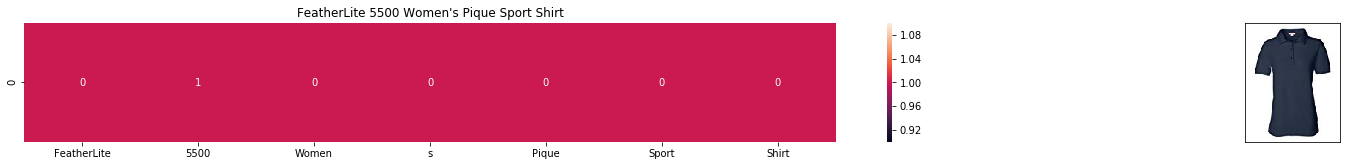

ASIN : B07254NFZG
Brand : FeatherLite
euclidean distance from the given image : 0.0


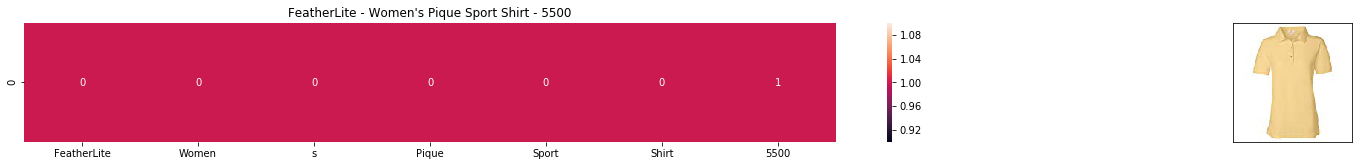

ASIN : B017XH0VE2
Brand : FeatherLite
euclidean distance from the given image : 0.0


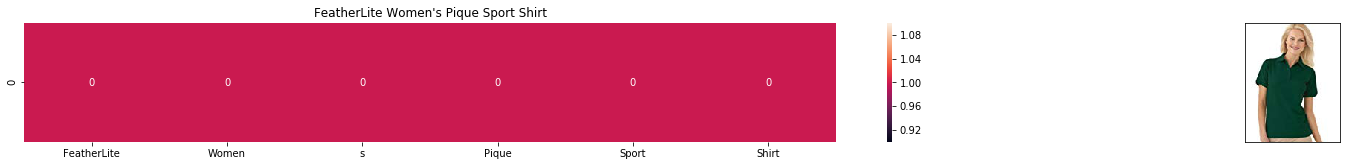

ASIN : B00CXZMGZW
Brand : FeatherLite
euclidean distance from the given image : 1.0


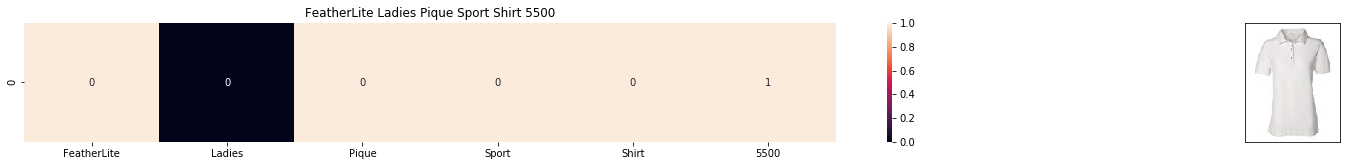

ASIN : B00E7VJ4TG
Brand : FeatherLite
euclidean distance from the given image : 1.4142135623730951


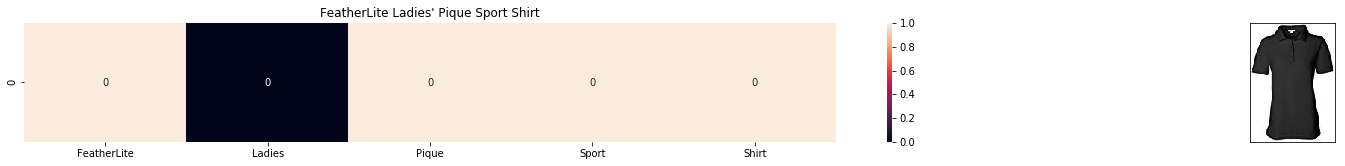

ASIN : B0753RJF9M
Brand : FeatherLite
euclidean distance from the given image : 1.7320508075688772


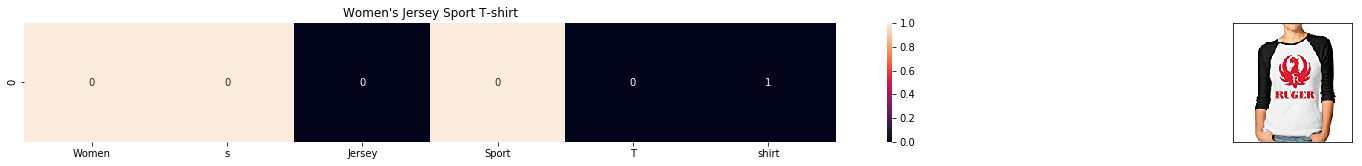

ASIN : B01IFB00L4
Brand : Best Music Posters
euclidean distance from the given image : 2.0


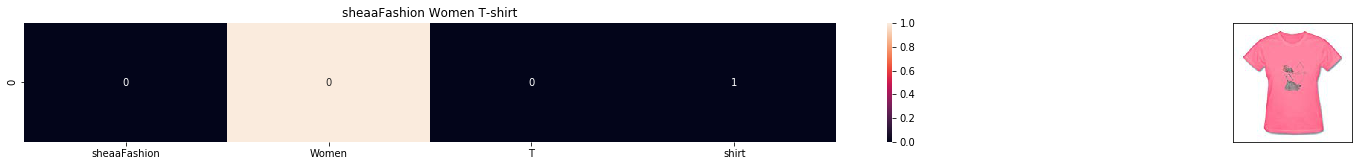

ASIN : B072K54PQG
Brand : FDGHAaa1
euclidean distance from the given image : 2.23606797749979


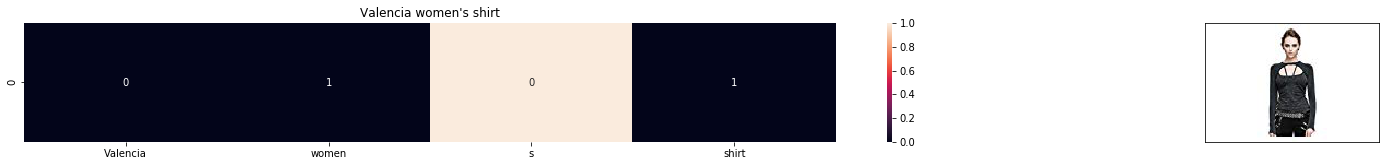

ASIN : B07193P2P5
Brand : Devils Fashion
euclidean distance from the given image : 2.23606797749979


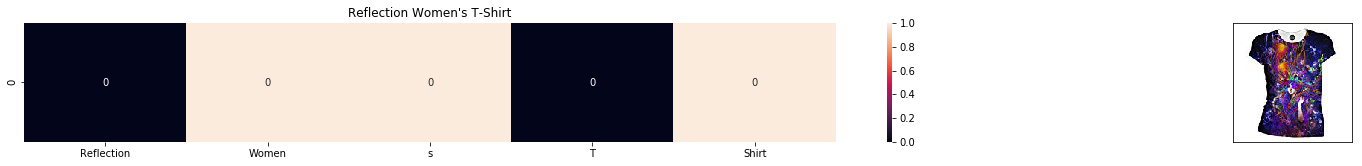

ASIN : B0758XSXCM
Brand : On Cue Apparel
euclidean distance from the given image : 2.23606797749979


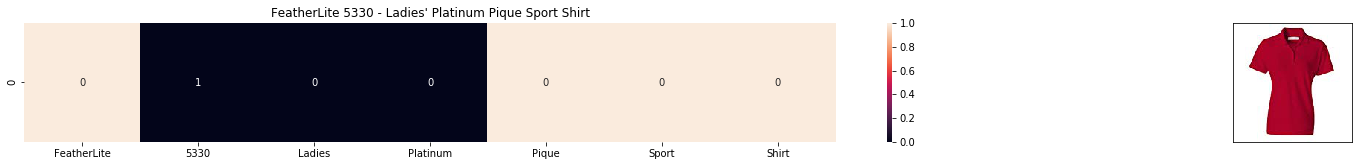

ASIN : B017XH1G1Y
Brand : FeatherLite
euclidean distance from the given image : 2.23606797749979


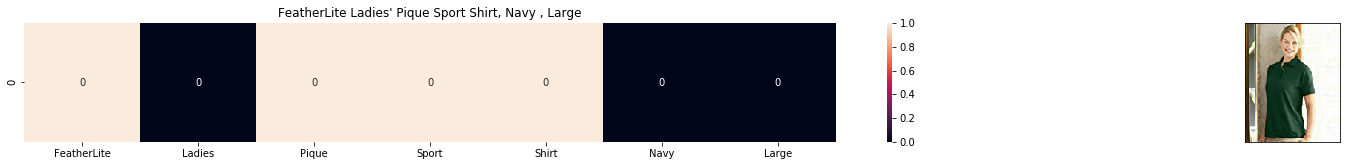

ASIN : B003BSRTP2
Brand : FeatherLite
euclidean distance from the given image : 2.23606797749979


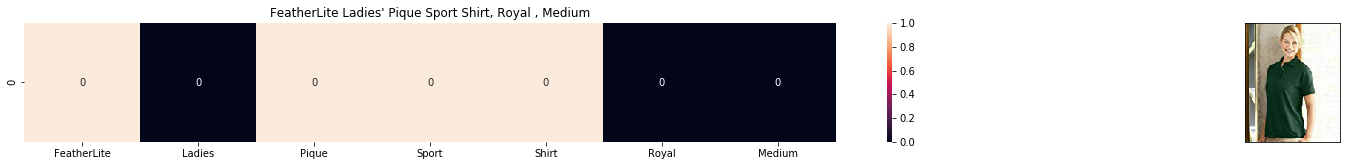

ASIN : B003BSRU60
Brand : FeatherLite
euclidean distance from the given image : 2.23606797749979


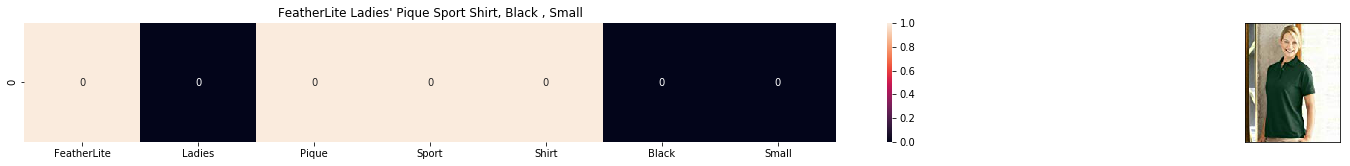

ASIN : B003BSNUBO
Brand : FeatherLite
euclidean distance from the given image : 2.23606797749979


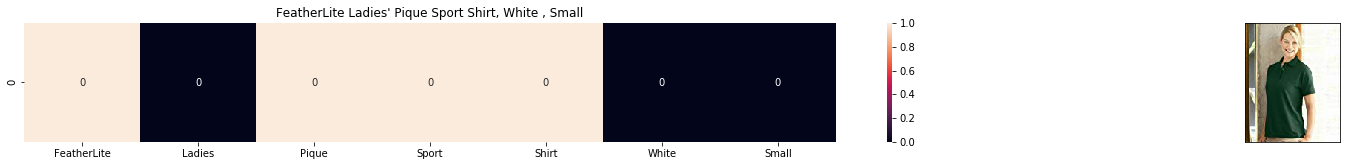

ASIN : B003BSRULU
Brand : FeatherLite
euclidean distance from the given image : 2.23606797749979


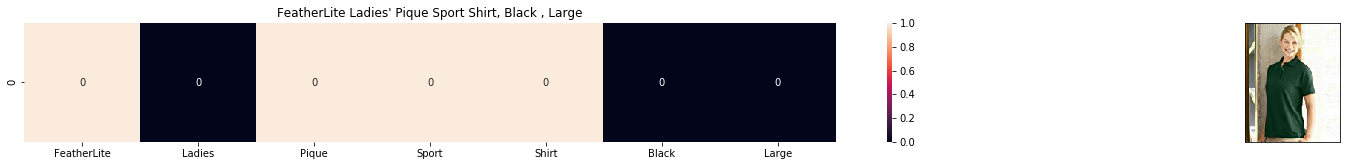

ASIN : B003BSRRDG
Brand : FeatherLite
euclidean distance from the given image : 2.23606797749979


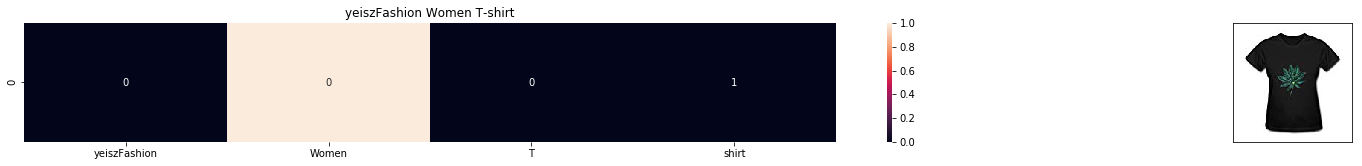

ASIN : B071GC9444
Brand : FDGHAaa1
euclidean distance from the given image : 2.23606797749979


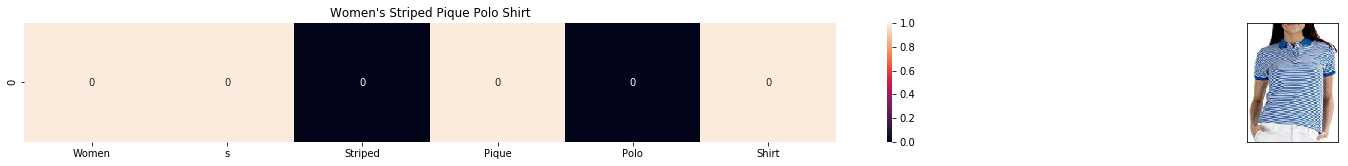

ASIN : B005XQW6BW
Brand : Nantucket
euclidean distance from the given image : 2.23606797749979


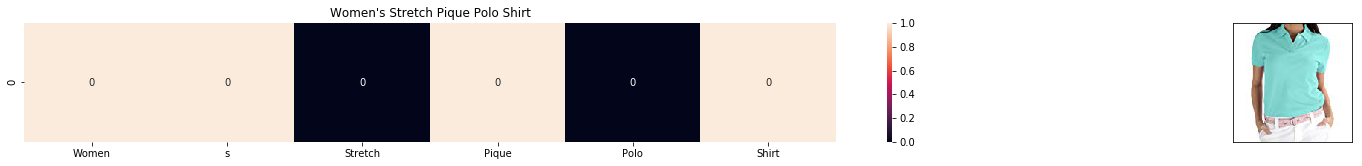

ASIN : B005XQSKGC
Brand : Nantucket Brand
euclidean distance from the given image : 2.23606797749979


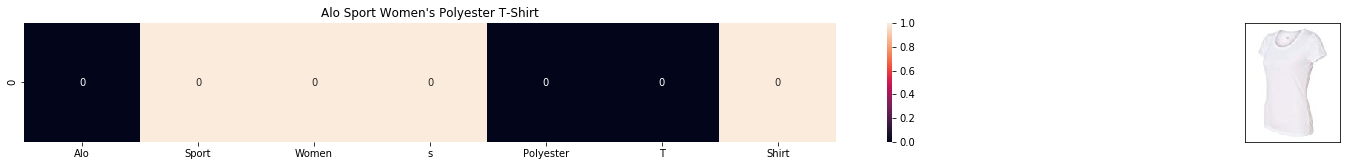

ASIN : B00BBQCCKS
Brand : ALO Sport
euclidean distance from the given image : 2.23606797749979


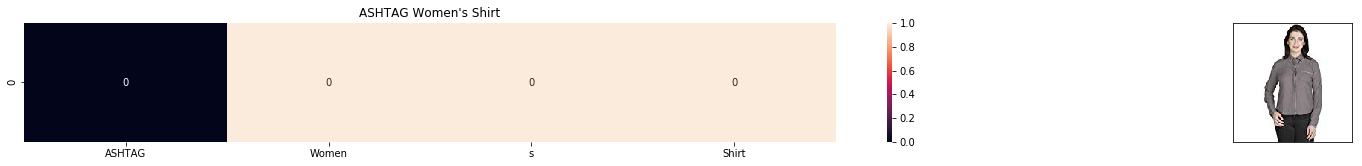

ASIN : B018M5P1KS
Brand : ASHTAG
euclidean distance from the given image : 2.23606797749979


In [42]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(550,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title